<h1 style="text-align: center">Extracting Features From the History of Crimes Recently Committed and Within the Area of Influence: A Feature Engineering Strategy</h1>

This document presents a feature engineering strategy that supports the predictive power of an ensemble-based approach to crime classification. First, to each crime in the dataset, several features are extracted from the history of recent incidents that are within its area of influence. Next, a methodology to develop a stacked generalization ensemble is proposed. In particular, several base models are trained on stratified subsets of the whole dataset that are different from each other. Then, the first-level predictions, i.e., the outputs from the base models, are combined according to the stacking technique the meta-model implements to make the second-level predictions. Experimental results show that training a classifier to combine the predictions from the base models outperforms the straightforward stacking technique of soft voting. Nevertheless, the lowest multi-class logarithmic loss obtained, i.e., 2.56044, is the result of combining the second-level predictions.

<span style="font-size: 128.6%;"><b>Contents</b></span>

<ul style="list-style-type: none; padding-left: 0 !important;">
  <li><a href="#Project-Description">Project Description</a></li>
  <li><a href="#0.-Requirements">0. Requirements</a></li>
  <li><a href="#1.-Data-Preprocessing">1. Data Preprocessing</a></li>
  <li><a href="#2.-Feature-Engineering">2. Feature Engineering</a></li>
  <li>
      <a href="#3.-Crime-Classification">3. Crime Classification</a>
      <ul style="list-style-type: none; padding-left: 1em !important;">
          <li><a href="#3.1-Train-Test-Split">3.1 Train-Test Split</a></li>
          <li><a href="#3.2-Baseline-Model">3.2 Baseline Model</a></li>
          <li><a href="#3.3-Discriminative-Features">3.3 Discriminative Features</a></li>
          <li>
              <a href="#3.4-Stacking-Ensemble">3.4 Stacking Ensemble</a>
              <ul style="list-style-type: none; padding-left: 1em !important;">
                  <li><a href="#3.4.1-Results">3.4.1 Results</a></li>
                  <li><a href="#3.4.2-Late-Submission">3.4.2 Late Submission</a></li>
              </ul>
          </li>
      </ul>
  </li>
  <li><a href="#4.-Conclusion">4. Conclusion</a></li>
</ul>

## Project Description

[San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/) is a Kaggle challenge related to multi-class classification. In particular, each record in the dataset must be classified into one out of 39 categories of crime. There are 12 years of criminal records on which predictive models must be trained and evaluated. To get a sense of the dataset, an overview of its attributes is presented below:

* **Dates**: the DateTime the crime was committed at
* **Category**: the category of the committed crime. (This is the target variable.)
* **Descript**: a further description of the crime
* **DayOfWeek**: day of the week on which the crime was committed
* **PdDistrict**: the Police Department District that attended the crime incident
* **Resolution**: an (optional) explanation on how the crime was resolved
* **Address**: "the approximate street address of the crime incident"
* **X**: the longitude of the location the crime was committed
* **Y**: the latitude of the location the crime was committed

In total, the dataset comprises 1,762,311 crime records, 878,049 of which have a category (i.e., the training set). These data range from January 2003 to May 2015.

Lastly, the performance of predictive models is evaluated on the test set using the multi-class logarithmic loss metric.

## 0. Requirements

In order to encourage reproducibility, the following is a list of technologies used, as well as their respective version:

1. Python **3.7.2**.
2. NumPy **1.17.2**.
3. SciPy **1.3.1**.
4. Scikit-learn **0.21.3**.
5. pandas **0.25.1**.
6. Matplotlib **3.1.1**.
7. Numba **0.48.0**.
8. tabulate **0.8.6**.

In [1]:
import copy
import os
import re

import joblib
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import tabulate
from IPython.display import display
from IPython.display import HTML
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
CURRENT_PATH = os.path.abspath(os.getcwd())
DATA_PATH = os.path.join(CURRENT_PATH, 'data')

DATE_FORMAT = '%Y-%m-%d %H:%M:%S'
RANDOM_STATE = 91

ALGORITHMS = {
    'logit': {
        'estimator': LogisticRegression(
            penalty='l2',
            solver='liblinear',
            multi_class='ovr'
            ),
        'predict_proba': True,
        'param_grid': None
        },
    'gb': {
        'estimator': GradientBoostingClassifier(),
        'predict_proba': True,
        'param_grid': None
        },
    'rf': {
        'estimator': RandomForestClassifier(),
        'predict_proba': True,
        'param_grid': None
        }
    }

In [3]:
FNAMES = {
    'original-train': 'train.csv',
    'train': 'projected-train.csv',
    'original-test': 'test.csv',
    'test': 'projected-test.csv',
    'sample-submission': 'sampleSubmission.csv',
    'crime-dataset': 'crime-dataset.csv',
    'baseline': 'baseline-models.csv'
    }

FNAMES = {key: os.path.join(DATA_PATH, fname) for key, fname in FNAMES.items()}

## 1. Data Preprocessing

Let's map each crime category to its numerical representation.

In [4]:
with open(FNAMES['sample-submission']) as f:
    for i, row in enumerate(f):
        row = row.rstrip('\n')
        CRIME_CATEGORY = {category: j-1 for j, category in enumerate(row.split(',')) if j > 0}
        
        break

In [5]:
PROJECTION = ['Id', 'Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'X', 'Y']

As specified by the variable `PROJECTION`, let's project (or filter) the datasets.

In [6]:
def dataset_projection(in_fname, out_fname, projection=PROJECTION):
    valid_columns = []
    
    insert_id = False
    header, data = [], []
    with open(in_fname) as f:
        for i, row in enumerate(f):
            row = row.rstrip('\n')
            
            if i == 0:
                for j, col in enumerate(row.split(',')):
                    if col in projection:
                        header.append(col)
                        valid_columns.append(j)
                        
                insert_id = True if 'Id' not in header else False

                continue
                
            for old in re.findall(r'"[^"]+"', row):
                new = re.sub(r',', '|', old)                
                row = row.replace(old, new, 1)
                
            record = [
                re.sub(r'\|', ',', col).strip()
                for j, col in enumerate(row.split(',')) if j in valid_columns
                ]
            
            if len(record) != len(valid_columns):
                print('({}), Malformed columns at line {}'.format(in_fname, i+1))
                continue
            elif insert_id:
                record.insert(0, i-1)
                
            data.append(record)
            
    if insert_id:
        header.insert(0, 'Id')
    
    return header, data

In [7]:
datasets = [
    [FNAMES['original-train'], FNAMES['train']],
    [FNAMES['original-test'], FNAMES['test']]
    ]
for in_fname, out_fname in datasets:
    if os.path.isfile(out_fname):
        continue
    
    header, data = dataset_projection(in_fname, out_fname)
    df = pd.DataFrame(data, columns=header)
    
    df['Dates'] = pd.to_datetime(df['Dates'], format=DATE_FORMAT)
    df = df.sort_values(by=['Dates'])
    df['Dates'] = df['Dates'].dt.strftime(DATE_FORMAT)
    
    df.to_csv(out_fname, index=False)

Finally, let's append the test set to the training one.

In [8]:
if not os.path.isfile(FNAMES['crime-dataset']):
    columns = copy.deepcopy(PROJECTION)
    columns.remove('Category')
    columns.insert(0, 'Dataset')
    
    df = None
    for in_fname, dataset_type in [[FNAMES['train'], 'train'], [FNAMES['test'], 'test']]:
        dataset = pd.read_csv(in_fname)
        dataset['Dataset'] = dataset_type
        dataset = dataset[columns]
        
        df = dataset.copy(deep=True) if df is None else df.append(dataset)
        
    df['Dates'] = pd.to_datetime(df['Dates'], format=DATE_FORMAT)
    df = df.sort_values(by=['Dates', 'Dataset', 'Id'])
    df['Dates'] = df['Dates'].dt.strftime(DATE_FORMAT)
    
    df = df[columns]
    
    df.to_csv(FNAMES['crime-dataset'], index=False)

## 2. Feature Engineering

This process explores the ability to extract valuable information from the history of crimes recently committed and relatively close to each other. In other words, to each crime $c$, whose position in the map is depicted by the white filled circle and area of influence corresponds to the red filled circle, the history of crimes comprises all those from the previous hours before $c$ and within the area of influence.

![San Francisco Map](images/map.png "San Francisco Map")
<div align="center" style="margin-top: 10px;"><b>Figure 1</b>: A crime instance in San Francisco, which is is depicted by the white filled circle and whose area of influence corresponds to the red filled circle. Credits: <a href="https://www.google.com/maps">Google Maps</a> and <a href="https://www.mapdevelopers.com/draw-circle-tool.php">Map Developers</a></div>

Formally, let $x_{i}$ be each crime in the dataset and $S_{i}$ be the set comprising all crimes from the previous $t_{w}$ hours before $x_{i}$, then:

\begin{equation*}
S_{i} = \{ x_{j} | (x_{j}^{Dates} < x_{i}^{Dates}) \wedge (hours(x_{j}^{Dates}, x_{i}^{Dates}) < t_{w}) \}_{_{j \neq i}^{j = 1}}^{N}
\end{equation*}

\begin{equation*}
S_{i}^{PdDistrict} = \{ x_{j} | (x_{j}^{Dates} < x_{i}^{Dates}) \wedge (hours(x_{j}^{Dates}, x_{i}^{Dates}) < t_{w}) \wedge (x_{j}^{PdDistrict} = x_{i}^{PdDistrict}) \}_{_{j \neq i}^{j = 1}}^{N}
\end{equation*}

\begin{equation*}
S_{i}^{AreaOfInfluence} = \{ x_{j} | (x_{j}^{Dates} < x_{i}^{Dates}) \wedge (hours(x_{j}^{Dates}, x_{i}^{Dates}) < t_{w}) \wedge (distance(x_{i}^{Y}, x_{i}^{X}, x_{j}^{Y}, x_{j}^{X}) \leq r) \}_{_{j \neq i}^{j = 1}}^{N}
\end{equation*}

Afterward, several features are created by applying the aggregation function of count to each set of crimes as follows:

\begin{equation*}
x_{i}^{Agg_{1}} = |S_{i}|
\end{equation*}

\begin{equation*}
x_{i}^{Agg_{2}} = |S_{i}^{PdDistrict}|
\end{equation*}

\begin{equation*}
x_{i}^{Agg_{3}} = |S_{i}^{AreaOfInfluence}|
\end{equation*}

where,

* $N$ is the number of total crimes in the dataset,
* $| \cdot |$ is the cardinality of a set,
* $x_{i}^{Dates}$ is the DateTime when crime $x_{i}$ was committed,
* $hours(x_{j}^{Dates}, x_{i}^{Dates})$ is a function calculating the number of hours between the DateTimes $x_{j}^{Dates}$ and $x_{i}^{Dates}$,
* $t_{w}$ is the maximum number of hours between previous crime $x_{j}$ and crime $x_{i}$ in order to include the former in the set $S_{i}$,
* $x_{i}^{PdDistrict}$ is the Police Department District that attended the crime incident,
* $S_{i}^{PdDistrict}$ is the set of crimes attended by the same Police Department District,
* $x_{i}^{Y}$ and $x_{i}^{X}$ correspond to latitude and longitude, respectively,
* $distance(x_{i}^{Y}, x_{i}^{X}, x_{j}^{Y}, x_{j}^{X})$ is a function calculating the distance, in kilometers, between previous crime $x_{j}$ and crime $x_{i}$,
* $r$ is the maximum distance in kilometers between previous crime $x_{j}$ and crime $x_{i}$ in order to include the former in the set $S_{i}$,
* Note that $r$ can also be seen as the radius of the circle representing the area of influence of $x_{i}$,
* $S_{i}^{AreaOfInfluence}$ is the set of crimes within the area of influence of $x_{i}$.

Before continuing, some clarifications must be provided, namely:

* $t_{w}$ takes a value from the set $\{ 12, 24, 72, 168, 336 \}$.
* $r$ takes a value from the set $\{ 1, 2, 4, 8, 16 \}$.
* The three aggregated features described above result from assigning one value to $t_{w}$ and one to $r$ from their corresponding sets.

On the other hand, the following list comprises all attributes derived from the DateTime $x_{i}^{Dates}$:

1. Year,
2. Month,
3. Quarter,
4. Triannual,
5. Semester,
6. Day,
7. Day of week,
8. Whether or not the day of the week is a working day,
9. Fortnight,
10. Hour,
11. Four-hour period the hour of the crime belongs to,
12. Six-hour period the hour of the crime belongs to,
13. Twelve-hour period the hour of the crime belongs to.

In summary, the feature engineering process creates 13 date-derived features plus three aggregated features per each combination of values $t_{w}$ and $r$ take. To create these features, four raw features are used, namely: $Dates$, $PdDistrict$, $X$, and $Y$. Lastly, bear in mind that terms *feature* and *attribute* are used interchangeably throughout this document.

In [9]:
@numba.jit(nopython=True)
def compute_distance(
        lat_1, lon_1,
        lat_2, lon_2):
    """Compute distance between two locations.
    
    Returns
    -------
    float
        Distance in KM.
    
    Source: <https://stackoverflow.com/questions/19412462/>
    """
    # Approximate radius of earth in KM
    earth_radius = 6373.0
    
    lat_1 = np.radians(lat_1)
    lon_1 = np.radians(lon_1)
    
    lat_2 = np.radians(lat_2)
    lon_2 = np.radians(lon_2)
    
    lon_dist = lon_2 - lon_1
    lat_dist = lat_2 - lat_1
    
    a = (np.square(np.sin(lat_dist/2))
         + np.cos(lat_1)
         * np.cos(lat_2)
         * np.square(np.sin(lon_dist/2)))
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return earth_radius * c

In [10]:
@numba.jit(nopython=True)
def compute_aggregated_features(data, time_window, crime_radius):
    """Compute aggregated features.
    
    Parameters
    ----------
    data : np.ndarray, dtype('int64')
        A Numpy-like array of shape "(n, m)", where "n" is the number
        of records and "m" is the number of columns (or attributes).
        The strict order of the columns is presented below:
            Dataset,
            Id,
            Dates,
            PdDistrict,
            X - Longitude,
            Y - Latitude
    time_window : int
        Time window (in hours).
    crime_radius : list
        List of integers, each of which representing a radius in kilometers.
    """
    n = len(data)
    
    # Let's transform the time window into seconds
    time_window = time_window * 60 * 60
    
    aggregated_features = []
    for i in range(n):
        ts = data[i,2]    
        
        lower_ts = ts - time_window
        
        mask = ((lower_ts < data[:,2])
                & (data[:,2] < ts))
        
        historical_data = data[mask]
        m = len(historical_data)
        
        police_district = data[i,3]
        
        feature_vector = [
            int(data[i,0]),
            int(data[i,1]),
            m, # number of crimes within the time window
            0 # number of crimes attended by the same police department district
            ]
        feature_vector = feature_vector + [0 for j in crime_radius]
        
        lat_1 = data[i,5]
        lon_1 = data[i,4]
        
        for j in range(m):
            feature_vector[3] += 1 if police_district == historical_data[j,3] else 0
            
            lat_2 = historical_data[j,5]
            lon_2 = historical_data[j,4]
            
            # Let's compute the number of crimes within each given radius
            distance = compute_distance(lat_1, lon_1, lat_2, lon_2)
            
            for k, rad in enumerate(crime_radius):
                feature_vector[4+k] += 1 if distance <= rad else 0
                
        aggregated_features.append(feature_vector)
        
    return aggregated_features

In [11]:
def derive_date_attributes(df, column, drop_column=True):
    df['Year'] = df[column].dt.year
    
    df['Month'] = df[column].dt.month
    df['Quarter'] = df[column].dt.quarter
    
    df['Triannual'] = 0
    for i, (min_m, max_m) in enumerate([[1, 4], [5, 8], [9, 12]]):
        df.loc[((min_m <= df['Month']) & (df['Month'] <= max_m)), 'Triannual'] = i + 1
    
    df['Semester'] = 1
    df.loc[(df['Quarter'] > 2), 'Semester'] = 2
    
    df['Day'] = df[column].dt.day
    df['DayOfWeek'] = df[column].dt.dayofweek
    
    df['WorkingDay'] = 1
    df.loc[(df['DayOfWeek'] > 4), 'WorkingDay'] = 0
    
    df['Fortnight'] = 1
    df.loc[(df['Day'] > 15), 'Fortnight'] = 2
    
    df['Hour'] = df[column].dt.hour
    
    hourly_periods = {
        'four': [[i, i+3] for i in range(0, 24, 4)],
        'six': [[i, i+5] for i in range(0, 24, 6)],
        'twelve': [[i, i+11] for i in range(0, 24, 12)],
        }
    
    for str_period, period in hourly_periods.items():
        period_column = '{}HourPeriod'.format(str_period.title())
        df[period_column] = 0
        
        for i, (min_hr, max_hr) in enumerate(period):
            df.loc[((min_hr <= df['Hour']) & (df['Hour'] <= max_hr)), period_column] = i + 1
    
    if drop_column:
        df = df.drop(columns=[column])
    
    return df

In [12]:
def feature_engineering(
        df, data, time_windows,
        idx_to_dataset, idx_to_district,
        crime_radius=[1, 2, 4, 8, 16]):
    """Compute the process of feature engineering."""
    df = df[['Dataset', 'Id', 'PdDistrict', 'Dates']]
    df = df.replace({'Dataset': idx_to_dataset, 'PdDistrict': idx_to_district})
    
    df = derive_date_attributes(df, 'Dates')
    
    crime_radius = np.array(crime_radius, dtype=int)
    
    agg_ds_fname = os.path.join(DATA_PATH, 'agg-dataset-{}H.csv')
    cum_ds_fname = os.path.join(DATA_PATH, 'agg-dataset-{}H-cumulative.csv')    
    
    for i, time_window in enumerate(time_windows):
        agg_ds_fname_1 = agg_ds_fname.format(time_window)
        cum_ds_fname_1 = cum_ds_fname.format(time_window)
        
        if (os.path.isfile(cum_ds_fname_1)
                or (i == 0 and os.path.isfile(agg_ds_fname_1))):
            continue
        elif os.path.isfile(agg_ds_fname_1):
            agg_ds = pd.read_csv(agg_ds_fname_1)
            
            for col in agg_ds.columns:
                if col in ['Dataset']:
                    continue
                
                agg_ds[col] = pd.to_numeric(agg_ds[col])
        else:
            agg_ds = compute_aggregated_features(data, time_window, crime_radius)
            
            prefix = '{}H_'.format(time_window)
            agg_ds_columns = (['Dataset', 'Id']
                              + [(prefix + col) for col in ['Crimes', 'CrimesAttendedByPdDistrict']]
                              + [(prefix + 'CrimesWithin{}KMRad'.format(rad)) for rad in crime_radius])
            
            agg_ds = pd.DataFrame(agg_ds, columns=agg_ds_columns)
            agg_ds = agg_ds.astype({col: 'int32' for col in agg_ds_columns})
            
            agg_ds['Dataset'] = agg_ds['Dataset'].map(idx_to_dataset)
            
            agg_ds.to_csv(agg_ds_fname_1, index=False)
        
        if i == 0:
            continue
            
        cum_ds = agg_ds.copy(deep=True)
        agg_ds = None
        
        for j in range(i):
            agg_ds_fname_2 = agg_ds_fname.format(time_windows[j])
            
            agg_ds = pd.read_csv(agg_ds_fname_2)
            
            for col in agg_ds.columns:
                if col in ['Dataset']:
                    continue
                
                agg_ds[col] = pd.to_numeric(agg_ds[col])
                
            cum_ds = pd.merge(agg_ds, cum_ds, on=['Dataset', 'Id'], how='inner')
            
        cum_ds = pd.merge(df, cum_ds, on=['Dataset', 'Id'], how='inner')
        
        cum_ds.to_csv(cum_ds_fname_1, index=False)

In [13]:
df = pd.read_csv(FNAMES['crime-dataset'])

df['Dates'] = pd.to_datetime(df['Dates'], format=DATE_FORMAT)

In [14]:
DATASET_TO_IDX = {dataset: i for i, dataset in enumerate(df['Dataset'].unique())}
IDX_TO_DATASET = {i: dataset for dataset, i in DATASET_TO_IDX.items()}

df['Dataset'] = df['Dataset'].map(DATASET_TO_IDX)

In [15]:
DISTRICT_TO_IDX = {district: i for i, district in enumerate(df['PdDistrict'].unique())}
IDX_TO_DISTRICT = {i: district for district, i in DISTRICT_TO_IDX.items()}

df['PdDistrict'] = df['PdDistrict'].map(DISTRICT_TO_IDX)

In [16]:
PROJECTION = (['Dataset']
              + [col for col in PROJECTION if col not in ['Category', 'DayOfWeek']])

df = df[PROJECTION]
df = df.sort_values(by=['Dates', 'Dataset', 'Id'])

crimes = df.copy(deep=True)
crimes['ts'] = crimes['Dates'].values.astype(np.int64) // 10 ** 9
crimes = crimes[[('ts' if col == 'Dates' else col) for col in PROJECTION]].to_numpy().astype(float)

Bear in mind that running the feature engineering process takes a long time; approximately 7.3 hours.

In [17]:
TIME_WINDOWS = [12, 24, 72, 168, 336]

feature_engineering(df, crimes, TIME_WINDOWS, IDX_TO_DATASET, IDX_TO_DISTRICT)

## 3. Crime Classification

The first subsection presents how the whole dataset is split into training, validation, and test sets. Then, the baseline model and the discriminative power of each set of features are discussed in subsections 3.2 and 3.3, respectively. Finally, the methodology to build stacked generalization ensembles is developed in subsection 3.4.

### 3.1 Train-Test Split

Let's split the whole dataset of crimes into training, validation and test datasets. Please recall that the original training and test datasets, as downloaded from Kaggle, were merged to run the feature engineering process. Lastly, the training dataset will be split into two folds: the first one, approximately 80% of the data, is intended to train prediction models; the second one is aimed at validating each prediction model on an independent dataset.

In [18]:
VALIDATION_SIZE = 0.2

for time_window in TIME_WINDOWS:
    in_fname = os.path.join(DATA_PATH, 'agg-dataset-{}H-cumulative.csv'.format(time_window))
    if not os.path.isfile(in_fname):
        continue
    
    window_path = {
        '/': os.path.join(DATA_PATH, '{}H'.format(time_window))
        }
    window_path['data'] = os.path.join(window_path['/'], 'data')
    
    for path in window_path.values():
        if not os.path.isdir(path):
            os.makedirs(path)
    
    window_fnames = {
        ds: os.path.join(window_path['data'], '{}.csv'.format(ds))
        for ds in ['train', 'validation', 'test']
        }
    
    split_data = False
    for fname in window_fnames.values():
        if not os.path.isfile(fname):
            split_data = True
            break
            
    if not split_data:
        continue
    
    df = pd.read_csv(in_fname)    
    
    df['Id'] = pd.to_numeric(df['Id'])
    
    columns = df.columns    
    
    numerical_columns = [col for col in columns if re.match(r'[0-9]{2,3}H_', col)]    
    
    categorical_columns = ['PdDistrict']
    for col in columns:
        if (col not in numerical_columns
                and col not in ['Dataset', 'Id', 'PdDistrict']):
            categorical_columns.append(col)
    
    if not os.path.isfile(window_fnames['test']):
        test = df.loc[df['Dataset']=='test'].drop(columns=['Dataset'])
        
        test = test.sort_values(by=['Id'])
        
        columns = ['Id'] + categorical_columns + numerical_columns
        test = test[columns]
        
        test.to_csv(window_fnames['test'], index=False)
        test = None
        
    df = df.loc[df['Dataset']=='train'].drop(columns=['Dataset'])
    
    train = pd.read_csv(FNAMES['train'])    
    
    train['Id'] = pd.to_numeric(train['Id'])
    train = train[['Id', 'Category']]
    
    assert len(df) == len(train)
    
    df = pd.merge(df, train, on=['Id'], how='inner')
    train = None
    
    columns = ['Id'] + categorical_columns + numerical_columns + ['Category']
    df = df[columns]
    
    # The validation dataset is a stratified random sample
    
    validation = None
    for category in CRIME_CATEGORY.keys():
        category_samples = df.loc[df['Category']==category]
        
        sample_size = len(category_samples) * VALIDATION_SIZE
        sample_size = int(np.round(sample_size, 0))
        
        sample = category_samples.sample(n=sample_size, replace=False, random_state=RANDOM_STATE)
        
        validation = (
            validation.append(sample).reset_index(drop=True)
            if validation is not None
            else sample.copy(deep=True)
            )
    
    validation.to_csv(window_fnames['validation'], index=False)
    
    df = df.loc[~df['Id'].isin(validation['Id'].values)]
    df.to_csv(window_fnames['train'], index=False)

### 3.2 Baseline Model

Let's build a strong baseline model according to the following criteria:

1. The training dataset will be used to learn prediction models.
2. The validation dataset will be used to rank prediction models, as they haven't seen these data during their training process.
3. The entire set of features will be used.
4. A set of several machine learning algorithms will be used to learn prediction models. Thus, a prediction model will be learned per each combination of algorithm and time window.
5. There will not be hyperparameter optimization. Machine learning algorithms will be used with their hyperparameters default values.

In [19]:
def identify_attributes(
        df, attributes, time_window, window_type,
        attributes_to_exclude=['Id', 'PdDistrict', 'Category']
        ):
    """Identify the attribute names the sets of numerical and categorical attributes consist of.
    
    Returns
    -------
    list
        List of attribute names the set of numerical features consists of.
    list
        List of attribute names the set of categorical features consists of.
    """
    columns = df.columns
    
    num_attr_re = re.compile(
        r'{}H_'.format('[0-9]{2,3}' if window_type == 'cumulative' else time_window)
        )
    num_attr = (
        [col for col in columns if num_attr_re.match(col)]
        if attributes in ['num', 'all']
        else []
        )
    
    cat_attr = []
    for col in columns:
        if attributes == 'num':
            break
        
        if (col not in attributes_to_exclude
                and not re.match(r'[0-9]{2,3}H_', col)):
            cat_attr.append(col)
            
    return num_attr, cat_attr

In [20]:
def build_model(
        train, validation,
        attributes, y_column,
        time_window, window_type,
        estimator, param_grid,
        predict_proba,
        return_pred=False,
        return_clf=False
        ):
    """Build a prediction model.
    
    Parameters
    ----------
    train : pd.DataFrame
    
    validation : pd.DataFrame
    
    attributes : str
        The set of attributes to be used as input by the estimator.
        
        - If "cat", then the date-derived attributes are used.
        - If "num", then the aggregated attributes computed using the time window are used.
        - If "all", then the union of the attributes "cat" and "raw" is used.
        
        Bear in mind that, whatever the set of attributes,
        the attribute "PdDistrict" is always used.
    
    y_column : str
        Which is the target variable? This variable must
        be in both training and validation datasets.
    
    time_window : int
        Time window (in hours).
    
    window_type : str
        Whether to use other windows whose time in hours is less than the specified time window value.
        
        - If "exact", then aggregated attributes that were computed using only the specified time
          window, are used.
        - If "cumulative", then aggregated attributes that were computed using windows whose time
          in hours is less than the specified time window, are also used.
    
    estimator
        A scikit-learn classification estimator.
    
    param_grid : dict
        Dictionary of parameters, as well as their corresponding values, for the estimator.
        This enables an exhaustive search over the specified parameter values through cross-validation.
        
    predict_proba : bool
        Whether or not the estimator supports the "predict_proba()" method.
    
    return_pred : bool
    
    return_clf : bool
    """
    num_attr, cat_attr = identify_attributes(train, attributes, time_window, window_type)
    
    if ('PdDistrict' in train.columns
            and 'PdDistrict' not in cat_attr):
        cat_attr.insert(0, 'PdDistrict')
    
    X_train_cat = train[cat_attr].to_numpy()
    X_valid_cat = validation[cat_attr].to_numpy()
    
    X_train_num = None
    X_valid_num = None
    
    scaler = StandardScaler()
    if attributes in ['num', 'all']:
        X_train_num = scaler.fit_transform(train[num_attr].to_numpy().astype(float))
        X_valid_num = scaler.transform(validation[num_attr].to_numpy().astype(float))
    
    X_train = (
        np.hstack([X_train_cat, X_train_num])
        if X_train_num is not None
        else X_train_cat
        )
    
    X_valid = (
        np.hstack([X_valid_cat, X_valid_num])
        if X_valid_num is not None
        else X_valid_cat
        )
    
    y_train = train[y_column].values.astype(int)
    y_valid = validation[y_column].values.astype(int)
    
    clf = estimator
    
    if isinstance(param_grid, dict):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        
        scoring = 'neg_log_loss' if predict_proba else 'f1_macro'
        clf = GridSearchCV(
            estimator=estimator, param_grid=param_grid, cv=cv,
            n_jobs=5, scoring=scoring, iid=False, refit=True
            )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict_proba(X_valid) if predict_proba else clf.predict(X_valid)    
    
    score = log_loss(y_valid, y_pred)
    
    if not return_pred and not return_clf:
        return score
    elif return_pred and not return_clf:
        return score, y_pred
    elif not return_pred and return_clf:
        return score, clf, scaler
    else:
        return score, y_pred, clf, scaler

In [21]:
def find_baseline_model(
        time_windows, out_fname,
        district_to_idx=DISTRICT_TO_IDX,
        crime_category=CRIME_CATEGORY,
        algorithms=ALGORITHMS):
    """Find the best baseline model, as specified above."""
    results = []
    results_header = ['TimeWindow', 'Algorithm', 'LogLoss']
    
    for time_window in time_windows:
        window_path = {
            '/': os.path.join(DATA_PATH, '{}H'.format(time_window))
            }
    
        window_path['data'] = os.path.join(window_path['/'], 'data')
        
        train = pd.read_csv(os.path.join(window_path['data'], 'train.csv'))
        train = train.replace({'PdDistrict': district_to_idx, 'Category': crime_category})
        
        validation = pd.read_csv(os.path.join(window_path['data'], 'validation.csv'))
        validation = validation.replace({'PdDistrict': district_to_idx, 'Category': crime_category})
        
        for algo, settings in algorithms.items():
            score = build_model(
                train, validation,
                'all', 'Category',
                time_window, 'cumulative',
                settings['estimator'], None,
                settings['predict_proba']
                )
            results.append([str(time_window), algo, '{:.5f}'.format(score)])
            
            pd.DataFrame(results, columns=results_header).to_csv(out_fname, index=False, mode='w')

Finding a strong baseline model takes a long time. Therefore, the set of time windows will be reduced, namely: 24, 72, and 168 hours.

In [22]:
TIME_WINDOWS.pop(0)

if not os.path.isfile(FNAMES['baseline']):
    find_baseline_model(TIME_WINDOWS[:-1], FNAMES['baseline'])

Let's analyze these results.

In [23]:
baseline_results = pd.read_csv(FNAMES['baseline'])

for col in baseline_results.columns:
    if col in ['Algorithm']:
        continue
    
    baseline_results[col] = pd.to_numeric(baseline_results[col])

Algorithm         gb    logit        rf
TimeWindow                             
24           8.13907  2.60024  14.50282
72           2.58249  2.59720  14.36502
168         10.42041  2.59499  14.36123


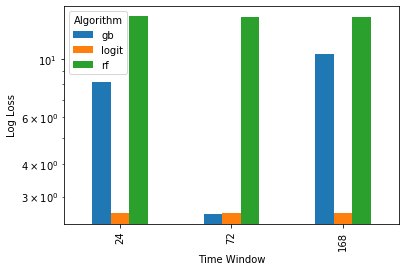

In [24]:
chart_data = baseline_results.pivot(index='TimeWindow', columns='Algorithm', values='LogLoss')

print(chart_data)

chart_data.plot(kind='bar', grid=False, legend=True, x=None)

plt.xlabel('Time Window')
plt.ylabel('Log Loss')

plt.yscale("log")

plt.show()

Notably, the Logistic Regression algorithm outperforms all of the machine learning algorithms, even though the best result, i.e., **2.58249**, was achieved by the Gradient Boosting algorithm on data aggregated using a time window of 72 hours. This conclusion is drawn as Logistic Regression is the most computationally efficient algorithm, and the difference between its best result and the overall best result is negligible.

On the other hand, let's analyze how having a larger time window contributes to crime classification. The Logistic Regression algorithm will be used to conduct this analysis.

In [25]:
FNAMES['logit-baseline'] = os.path.join(DATA_PATH, 'baseline-logit-models.csv')

if not os.path.isfile(FNAMES['logit-baseline']):
    logit_baseline = baseline_results.loc[baseline_results['Algorithm']=='logit']
    logit_baseline = logit_baseline.drop(columns=['Algorithm'])
    
    time_window = 336
    
    window_data_path = os.path.join(DATA_PATH, '{}H'.format(time_window), 'data')
    
    train = pd.read_csv(os.path.join(window_data_path, 'train.csv'))
    train = train.replace({'PdDistrict': DISTRICT_TO_IDX, 'Category': CRIME_CATEGORY})
    
    validation = pd.read_csv(os.path.join(window_path['data'], 'validation.csv'))
    validation = validation.replace({'PdDistrict': DISTRICT_TO_IDX, 'Category': CRIME_CATEGORY})
    
    algo = ALGORITHMS['logit']
    
    score = build_model(
        train, validation,
        'all', 'Category',
        time_window, 'cumulative',
        algo['estimator'], None,
        algo['predict_proba']
        )
    
    logit_baseline = logit_baseline.append({'TimeWindow': time_window, 'LogLoss': score}, ignore_index=True)
    
    logit_baseline.to_csv(FNAMES['logit-baseline'], index=False, mode='w')

   TimeWindow   LogLoss
0          24  2.600240
1          72  2.597200
2         168  2.594990
3         336  2.594697


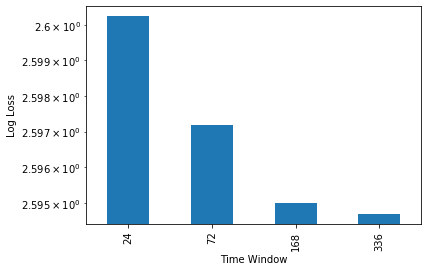

In [26]:
logit_baseline = pd.read_csv(FNAMES['logit-baseline'])

logit_baseline = logit_baseline.astype({'TimeWindow': 'int32', 'LogLoss': 'float64'})

print(logit_baseline)

logit_baseline.plot(x='TimeWindow', y='LogLoss', kind='bar', grid=False, legend=False)

plt.xlabel('Time Window')
plt.ylabel('Log Loss')

plt.yscale("log")

plt.show()

To sum up, the **baseline result** is **2.5947**.

### 3.3 Discriminative Features

The goal is to quantify how discriminative each set of features is, as well as each window type.

In [27]:
def discriminative_feature(
        time_window, algorithm, out_fname,
        district_to_idx=DISTRICT_TO_IDX,
        crime_category=CRIME_CATEGORY):
    """Quantify how discriminative each set of features is, as well as each window type."""
    window_data_path = os.path.join(DATA_PATH, '{}H'.format(time_window), 'data')
    
    train = pd.read_csv(os.path.join(window_data_path, 'train.csv'))
    train = train.replace({'PdDistrict': district_to_idx, 'Category': crime_category})
    
    validation = pd.read_csv(os.path.join(window_data_path, 'validation.csv'))
    validation = validation.replace({'PdDistrict': district_to_idx, 'Category': crime_category})
    
    grid = {
        'attributes': ['all', 'num', 'cat'],
        'window_type': ['exact', 'cumulative']
        }
    
    results = []
    results_header = ['Attributes', 'WindowType', 'LogLoss']
    
    for params in ParameterGrid(grid):
        score = build_model(
            train, validation,
            params['attributes'], 'Category',
            time_window, params['window_type'],
            algorithm['estimator'], None,
            algorithm['predict_proba']
            )
        
        results.append([params['attributes'], params['window_type'], '{:.5f}'.format(score)])
        
        pd.DataFrame(results, columns=results_header).to_csv(out_fname, index=False, mode='w')

In [28]:
FNAMES['discriminative-features'] = os.path.join(DATA_PATH, 'discriminative-features.csv')

if not os.path.isfile(FNAMES['discriminative-features']):
    discriminative_feature(
        336, ALGORITHMS['logit'], FNAMES['discriminative-features']
        )

In [29]:
discriminative_features = pd.read_csv(FNAMES['discriminative-features'])

discriminative_features['LogLoss'] = pd.to_numeric(discriminative_features['LogLoss'])

WindowType  cumulative    exact
Attributes                     
all            2.59470  2.60675
cat            2.65614  2.65614
num            2.60562  2.61889


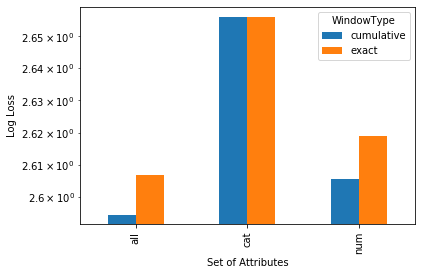

In [30]:
chart_data = discriminative_features.pivot(index='Attributes', columns='WindowType', values='LogLoss')

print(chart_data)

chart_data.plot(kind='bar', grid=False, legend=True)

plt.xlabel('Set of Attributes')
plt.ylabel('Log Loss')

plt.yscale("log")

plt.show()

These results show that the union of the numerical and categorical attributes contribute the most to discriminative power. In a like manner, aggregated attributes computed using cumulative time windows rather than an exact time window are more discriminative.

### 3.4 Stacking Ensemble

The methodology to develop a stacked generalization ensemble goes from splitting the initial dataset to producing the second-level predictions, as depicted in Figure 2.

![Stacking Ensemble](images/ensemble.svg "Stacking Ensemble")
<div align="center" style="margin-top: 10px;"><b>Figure 2</b>: Methodology to develop a stacked generalization ensemble</div>

Firstly, the initial dataset is split into $k$ folds through a stratified sampling method. In particular, the resulting folds are different from each other, i.e., a crime instance belongs to only one fold. Secondly, $k$ base models are trained, one per each fold. Thirdly, the first-level predictions, i.e., the outputs from the base models, are combined depending on the stacking technique the meta-model implements. Finally, the meta-model outputs the second-level predictions.

Furthermore, there are other considerations regarding the methodology described above, namely:

1. The way the first-level predictions are stacked depends on the stacking technique. If the stacking technique is model averaging, then such predictions are summed element-wise. Otherwise, matrices representing first-level predictions are stacked horizontally.
2. Accordingly, there are two stacking techniques a meta-model might implement, namely: training a classifier or model averaging.
3. Potentially, combining the predictions from several meta-models might be used to produce third-level predictions.

In [31]:
def write_in_file(fname, content, mode='w', insert_new_line=True):
    with open(fname, mode) as f:
        content = (content
                   + ('\n' if insert_new_line else ''))
        
        f.write(content)

In [32]:
@numba.jit(nopython=True)
def is_leap_year(year):
    return (True
            if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))
            else False)

In [33]:
@numba.jit(nopython=True)
def get_number_of_days_in_month(data):
    n = len(data)
    
    days_in_month = [31, None, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    result = []
    for i in range(n):
        year = data[i,0]
        month = data[i,1]
        
        result.append(
            (29 if is_leap_year(year) else 28)
            if month == 2
            else days_in_month[month-1]
            )
    
    return result

In [34]:
def encode_cyclical_attributes(
        df,
        attributes=['Month', 'Day', 'DayOfWeek', 'Hour']):
    """Encoding of cyclical attributes.
    
    Source: <http://blog.davidkaleko.com/feature-engineering-cyclical-features.html>
    """
    df['days_month'] = get_number_of_days_in_month(df[['Year', 'Month']].to_numpy().astype(int))
    
    for attr in attributes:
        max_val = df[attr].max() if attr != 'Day' else df['days_month']
        min_val = df[attr].min()
        
        if min_val == 1:
            df[attr] -= 1
        elif min_val == 0:
            max_val += 1
        
        df['{}_Sin'.format(attr)] = np.sin(df[attr] * 2 * np.pi / max_val)
        df['{}_Cos'.format(attr)] = np.cos(df[attr] * 2 * np.pi / max_val)
        
    attributes.append('days_month')
    df = df.drop(columns=attributes)
    
    return df

In [35]:
def encode_categorical_attributes(df, attributes):
    """One-Hot encoding of categorical attributes."""
    return pd.get_dummies(df, prefix=attributes, columns=attributes)

In [36]:
def split_training_data(df, n_splits, split_criterion='Category'):
    """Split training data in a stratified way without replacement.
    
    Please note that if the number of class instances is less than the
    number of splits, a stratified random sample with replacement will
    be performed.
    """
    criterion_values = {
        value: df.loc[df[split_criterion]==value].shape[0]
        for value in df[split_criterion].unique()
        }
    
    sampled_instances = []
    
    for i in range(n_splits):
        last_split = True if i == (n_splits-1) else False
        
        sample = None
        for value, size in criterion_values.items():
            mask = (df[split_criterion] == value) & (~df['Id'].isin(sampled_instances))
            criterion_sample = df.loc[mask]
            
            sample_size = size * (1/n_splits)
            sample_size = int(np.round(sample_size, 0))
            
            if sample_size < n_splits:
                criterion_sample = df.loc[(df[split_criterion] == value)]
                sample_size = np.min([n_splits, criterion_sample.shape[0]])
            
            if not last_split:
                criterion_sample = criterion_sample.sample(
                    n=sample_size, replace=False, random_state=RANDOM_STATE
                    )
                
            sample = (
                sample.append(criterion_sample).reset_index(drop=True)
                if sample is not None
                else criterion_sample.copy(deep=True)
                )
            
            sampled_instances += criterion_sample['Id'].values.tolist()
        
        yield sample

In [37]:
def build_meta_classifier(
        prediction_fnames,
        y_true,
        stack_method,
        estimator):
    """Build a meta classifier on the basis of several learners and a stacking method."""
    X = None
    
    for pred_fname in prediction_fnames:
        clf_pred = np.loadtxt(pred_fname, dtype=float, delimiter=',', skiprows=1)
        clf_pred = clf_pred[:,1:]
        
        if X is None:
            X = copy.deepcopy(clf_pred)
            continue
            
        X = np.add(X, clf_pred) if stack_method == 'soft_voting' else np.hstack([X, clf_pred])
    
    if stack_method == 'soft_voting':
        y_pred = X / len(prediction_fnames)
    else:
        cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)
        
        y_pred = cross_val_predict(
            estimator=estimator, X=X, y=y_true, cv=cv, n_jobs=5, method='predict_proba')
    
    return log_loss(y_true, y_pred)

In [38]:
def build_classifier_ensembles(
        out_fname,
        base_algorithm,
        meta_algorithm,
        crime_category=CRIME_CATEGORY,
        time_windows=TIME_WINDOWS):
    """Build classifier ensembles."""
    if not os.path.isfile(out_fname):
        content = [
            'Id',
            'TimeWindow',
            'NumberOfEstimators',
            'StackingMethod',
            'EncodingOfCyclicalAttributes',
            'LogLoss'
            ]        
        write_in_file(out_fname, ','.join(content))
    
    prediction_header = ['' for j in range(len(crime_category))]
    for crime, idx in crime_category.items():
        prediction_header[idx] = crime
    
    ensemble_grid = {
        'encode_cyclical_attr': ['cyclical', 'onehot'],
        'n_estimators': [3, 5, 7],
        'stack_method': ['soft_voting', 'clf'],
        'time_window': time_windows
        }
    ensemble_grid = ParameterGrid(ensemble_grid)
    
    for setting_id, settings in enumerate(ensemble_grid):
        time_window = settings['time_window']
        
        window_path = {
            '/': os.path.join(DATA_PATH, '{}H'.format(time_window))
            }        
        window_path['/data'] = os.path.join(window_path['/'], 'data')
        
        train = pd.read_csv(os.path.join(window_path['/data'], 'train.csv'))
        validation = pd.read_csv(os.path.join(window_path['/data'], 'validation.csv'))
        
        if settings['encode_cyclical_attr'] == 'cyclical':
            train = encode_cyclical_attributes(train)
            validation = encode_cyclical_attributes(validation)
        else:
            cyclical_attr = ['Month', 'Day', 'DayOfWeek', 'Hour']
            train = encode_categorical_attributes(train, cyclical_attr)
            validation = encode_categorical_attributes(validation, cyclical_attr)
        
        date_attr = [
            'Quarter', 'Triannual', 'Semester', 'Fortnight',
            'FourHourPeriod', 'SixHourPeriod', 'TwelveHourPeriod'
            ]        
        train = encode_categorical_attributes(train, date_attr)
        validation = encode_categorical_attributes(validation, date_attr)
        
        train = encode_categorical_attributes(train, ['PdDistrict'])
        validation = encode_categorical_attributes(validation, ['PdDistrict'])
            
        train = train.replace({'Category': crime_category})
        validation = validation.replace({'Category': crime_category})
        
        window_path['/prediction'] = os.path.join(
            window_path['/'],
            'prediction',
            'validation',
            'n_estimators={}'.format(settings['n_estimators']),
            'cyclical_attr={}'.format(settings['encode_cyclical_attr'])
            )
        
        if not os.path.isdir(window_path['/prediction']):
            os.makedirs(window_path['/prediction'])
            
        learners_result_fname = os.path.join(window_path['/prediction'], 'learners-result.csv')
        if not os.path.isfile(learners_result_fname):
            write_in_file(learners_result_fname, ','.join(['Clf', 'LogLoss']))
        
        prediction_fnames = []
        for i, train_sample in enumerate(split_training_data(train, settings['n_estimators'])):
            pred_fname = os.path.join(window_path['/prediction'], 'clf-{}-pred.csv'.format(i))
            prediction_fnames.append(pred_fname)
            
            if os.path.isfile(pred_fname):
                continue
            
            score, predictions = build_model(
                train_sample, validation,
                'all', 'Category',
                time_window, 'cumulative',
                base_algorithm['estimator'], None,
                base_algorithm['predict_proba'],
                return_pred=True
                )
            
            write_in_file(
                learners_result_fname, ','.join([str(i), '{:.5f}'.format(score)]), mode='a'
                )
            
            predictions = pd.DataFrame(predictions, columns=prediction_header)
            
            predictions['Id'] = validation['Id'].values
            predictions = predictions[['Id']+prediction_header]
            
            predictions.to_csv(pred_fname, float_format='%.5f', index=False)
        
        score = build_meta_classifier(
            prediction_fnames,
            validation['Category'].values.astype(int),
            settings['stack_method'],
            meta_algorithm['estimator']
            )
        
        content = [
            str(setting_id),
            str(time_window),
            str(settings['n_estimators']),
            settings['stack_method'],
            settings['encode_cyclical_attr'],
            '{:.5f}'.format(score)
            ]
        write_in_file(out_fname, ','.join(content), mode='a')

In [39]:
FNAMES['classifier-ensembles'] = os.path.join(DATA_PATH, 'classifier-ensembles.csv')

if not os.path.isfile(FNAMES['classifier-ensembles']):
    build_classifier_ensembles(
        FNAMES['classifier-ensembles'], ALGORITHMS['logit'], ALGORITHMS['logit']
        )

#### 3.4.1 Results

Before starting the analysis of results, some clarifications must be provided, namely:

1. The Logistic Regression algorithm was used to train base (or first-level) models and the meta-model (or stacking model).
2. There was no hyperparameter optimization. Hence,  hyperparameters default values were used.
3. The meta-model learns how to best combine the predictions from the base models.
4. However, training a meta-model is not the only technique to combine predictions. Model averaging, or soft voting, is also other technique used.

In [40]:
stacking_results = pd.read_csv(FNAMES['classifier-ensembles']).drop(columns='Id')

stacking_results = stacking_results.astype(
    {'TimeWindow': 'int32', 'NumberOfEstimators': 'int32', 'LogLoss': 'float64'}
    )

stacking_results = stacking_results.sort_values(by='LogLoss')

First of all, let's catch a glimpse of the top ten meta-models, as shown by the following table:

In [41]:
header = [
    'Rank',
    'Time Window',
    'Number of Estimators',
    'Stacking Technique',
    'Cyclical Attributes Encoding Technique',
    'Log Loss'
    ]

table = []

for i, (idx, row) in enumerate(stacking_results.iloc[:10].iterrows()):
    stack_technique = row['StackingMethod']
    stack_technique = (
        'Classifier' if stack_technique == 'clf' else stack_technique.replace('_', ' ')
        )
    stack_technique = stack_technique[0].upper() + stack_technique[1:]
    
    encoding_technique = row['EncodingOfCyclicalAttributes']
    encoding_technique = (
        'one-hot' if encoding_technique == 'onehot' else encoding_technique
        )
    encoding_technique = encoding_technique[0].upper() + encoding_technique[1:]
    
    table.append([
        str(i+1),
        str(row['TimeWindow']),
        str(row['NumberOfEstimators']),
        stack_technique,
        encoding_technique,
        '{:.5f}'.format(row['LogLoss'])
        ])

table = ('<center>'
         + tabulate.tabulate(table, header, tablefmt='html')
         + '</center>')

display(HTML(table))

Rank,Time Window,Number of Estimators,Stacking Technique,Cyclical Attributes Encoding Technique,Log Loss
1,336,7,Classifier,One-hot,2.56077
2,336,7,Soft voting,One-hot,2.56126
3,168,7,Classifier,One-hot,2.56178
4,168,7,Soft voting,One-hot,2.56212
5,168,5,Soft voting,One-hot,2.56214
6,72,5,Soft voting,One-hot,2.56239
7,336,5,Classifier,One-hot,2.56241
8,336,5,Soft voting,One-hot,2.56258
9,72,7,Soft voting,One-hot,2.56261
10,168,3,Soft voting,One-hot,2.56267


The above results let us draw the following conclusions:

1. Surprisingly, or at least for me, the technique that best handles cyclical attributes is one-hot encoding. Mapping each cyclical attribute onto a circle, through the trigonometric functions sine and cosine, doesn't outperform the basic one-hot encoding.
2. Model averaging, or soft voting, is a simple but powerful technique to combine predictions, as seven out of the top ten meta-models are built on it.
3. The larger the number of estimators, the better the discriminative power of the meta-model.
4. In a like manner, the larger the time window, the better the discriminative power of the meta-model, as eight out of the top ten meta-models use a time window of at least 168 hours to aggregate features.
5. Finally, it is worth mentioning that the best two meta-models combine the predictions from the same set of seven base models, but differ from each other by the stacking technique.

In [42]:
total_estimators = np.sum(stacking_results['NumberOfEstimators'].unique()
                          * stacking_results['TimeWindow'].unique().shape[0]
                          * stacking_results['EncodingOfCyclicalAttributes'].unique().shape[0])

display(HTML('In total, <b>{}</b> different base models were trained.'.format(total_estimators)))

Second of all, let's plot the performance of the <b>48</b> meta-models having as splitting criterion the cyclical attributes encoding technique.

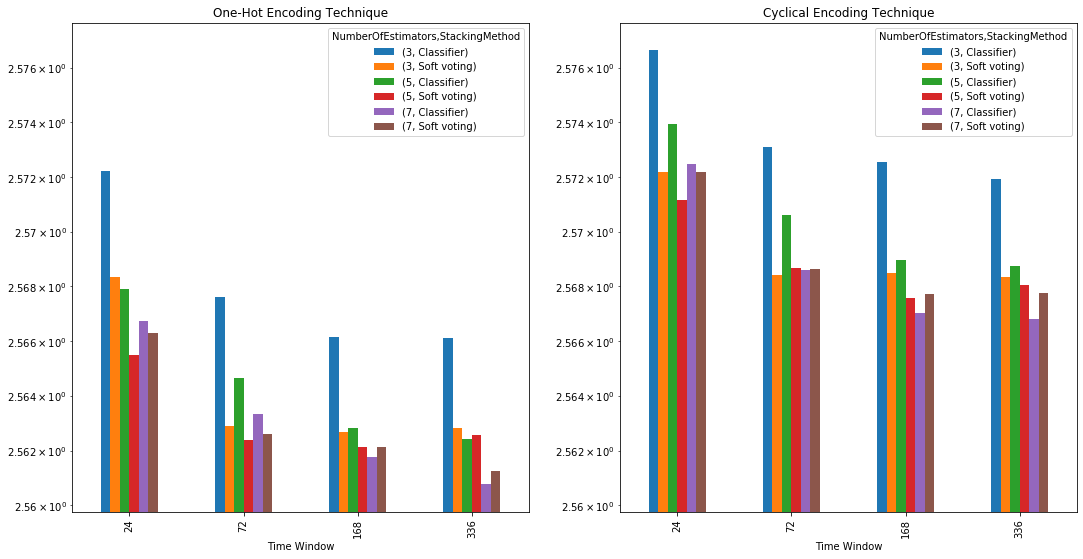

In [43]:
stacking_results = stacking_results.replace(
    {'StackingMethod': {'clf': 'Classifier', 'soft_voting': 'Soft voting'}}
    )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

alpha = 0.001
y_range = [
    stacking_results['LogLoss'].min() - alpha,
    stacking_results['LogLoss'].max() + alpha
    ]

for i, technique in enumerate(stacking_results['EncodingOfCyclicalAttributes'].unique()):
    mask = stacking_results['EncodingOfCyclicalAttributes'] == technique
    technique_results = stacking_results.loc[mask].drop(columns='EncodingOfCyclicalAttributes')
    
    technique_results = technique_results.pivot_table(
        index='TimeWindow', columns=['NumberOfEstimators', 'StackingMethod'], values='LogLoss'
        )
    
    technique_results.plot(kind='bar', ax=ax[i])
    
    technique = 'one-hot' if technique == 'onehot' else technique
    ax[i].set_title('{} Encoding Technique'.format(technique.title()))
    ax[i].set_xlabel('Time Window')

    ax[i].set_ylim(*y_range)
    ax[i].set_yscale("log")

Overall, the above figures support the finding that the technique that best handles cyclical attributes is one-hot encoding. Likewise, findings with respect to the time window and the stacking technique might also be generalized.

Third of all, let's get insights into how much the meta-model strengthens the discriminative power of the base models. To accomplish this, a comparison between the two best meta-models and the set of seven base models they are built on is conducted.

In [44]:
best_setting = stacking_results.iloc[0]

predictions_path = os.path.join(
    DATA_PATH,
    '{}H'.format(best_setting['TimeWindow']),
    'prediction',
    'validation',
    'n_estimators={}'.format(best_setting['NumberOfEstimators']),
    'cyclical_attr={}'.format(best_setting['EncodingOfCyclicalAttributes'])
    )

base_models_performance = pd.read_csv(os.path.join(predictions_path, 'learners-result.csv'))

header = ['Base Model', 'Log Loss']

table = [
    [str(i+1), '{:.5f}'.format(row['LogLoss'])]
    for i, (idx, row) in enumerate(base_models_performance.iterrows())
    ]

table = ('<center>'
         + tabulate.tabulate(table, header, tablefmt='html')
         + '</center>')

display(HTML(table))

Base Model,Log Loss
1,2.5726
2,2.56885
3,2.57124
4,2.57141
5,2.5707
6,2.56979
7,2.57093


With this in mind, let's quantify how much the two best meta-models strengthen the discriminative power w.r.t. the best, the worst, and the average base model.

In [45]:
header = [
    'Stacking Technique',
    'Best Base Model',
    'Worst Base Model',
    'Average Base Model'
    ]

table = []

comparison_values = [
    base_models_performance['LogLoss'].min(),
    base_models_performance['LogLoss'].max(),
    base_models_performance['LogLoss'].mean()
    ]

for i in range(2):
    stack_technique = stacking_results.iloc[i]['StackingMethod']
    
    score = stacking_results.iloc[i]['LogLoss']
    
    comparison = ['{:.3f} %'.format((np.abs(score-val)/val)*100) for val in comparison_values]
    comparison.insert(0, stack_technique)
    
    table.append(comparison)

table = ('<center>'
         + tabulate.tabulate(table, header, tablefmt='html')
         + '</center>')

display(HTML(table))

Stacking Technique,Best Base Model,Worst Base Model,Average Base Model
Classifier,0.315 %,0.460 %,0.390 %
Soft voting,0.295 %,0.441 %,0.371 %


To conclude, let's make the following final remarks:

1. The contributions of the two best meta-models to the discriminative power is almost negligible; all of them are below 0.5%. Even more, deploying any of these meta-models and its respective base models to a production environment might be unfeasible.
2. However, any gain, no matter how small, is worth in the context of a Kaggle competition.
3. The prediction from the two best meta-models on the test set will be used as late submissions to participate in this Kaggle competition.
4. Regarding the baseline, i.e., 2.5947 multi-class logarithmic loss, the best meta-model has outperformed it. The decrease (or gain) is around <b>1.31%</b>.

#### 3.4.2 Late Submission

As pointed out above, the final predictions to submit are those from the two best meta-models. These meta-models are built on the predictions from the same set of seven base models, but differ from each other by the stacking technique. Therefore, let's recall how the two best meta-models are built, as shown by the following table:

| Rank | Time Window | Number of Estimators | Stacking Technique | Cyclical Attributes Encoding Technique |
|------|-------------|----------------------|--------------------|----------------------------------------|
| 1    | 336         | 7                    | Classifier         | One-hot                                |
| 2    | 336         | 7                    | Soft voting        | One-hot                                |

In [46]:
def train_and_persist_base_models(
        train_fname,
        validation_fname,
        time_window,
        n_estimators,
        base_algorithm,
        meta_algorithm,
        models_path
        ):
    """Fit the base models on the training dataset and persist them."""
    if not os.path.isdir(models_path):
        os.makedirs(models_path)
        
    results_fname = os.path.join(models_path, 'base-learners-result.csv')
    if not os.path.isfile(results_fname):
        write_in_file(results_fname, ','.join(['Clf', 'LogLoss']))
    
    train = pd.read_csv(train_fname)
    validation = pd.read_csv(validation_fname)
    
    cyclical_attr = [
        'Month', 'Day', 'DayOfWeek', 'Hour'
        ]
    train = encode_categorical_attributes(train, cyclical_attr)
    validation = encode_categorical_attributes(validation, cyclical_attr)
    
    date_attr = [
        'Quarter', 'Triannual', 'Semester', 'Fortnight',
        'FourHourPeriod', 'SixHourPeriod', 'TwelveHourPeriod'
        ]
    train = encode_categorical_attributes(train, date_attr)
    validation = encode_categorical_attributes(validation, date_attr)
    
    train = encode_categorical_attributes(train, ['PdDistrict'])
    validation = encode_categorical_attributes(validation, ['PdDistrict'])
    
    train = train.replace({'Category': CRIME_CATEGORY})
    validation = validation.replace({'Category': CRIME_CATEGORY})
    
    X = None
        
    for i, train_sample in enumerate(split_training_data(train, n_estimators)):
        clf_fname = os.path.join(models_path, 'clf-{}.joblib'.format(i))
        scaler_fname = os.path.join(models_path, 'clf-{}-scaler.joblib'.format(i))
        
        if os.path.isfile(clf_fname):
            continue
        
        score, predictions, clf, scaler = build_model(
            train_sample, validation,
            'all', 'Category',
            time_window, 'cumulative',
            base_algorithm['estimator'], None,
            base_algorithm['predict_proba'],
            return_pred=True,
            return_clf=True
            )
        
        X = copy.deepcopy(predictions) if X is None else np.hstack([X, predictions])
        
        write_in_file(results_fname, ','.join([str(i), '{:.5f}'.format(score)]), mode='a')
        
        joblib.dump(clf, clf_fname)
        joblib.dump(scaler, scaler_fname)
    
    clf_ensemble_fname = os.path.join(models_path, 'clf-ensemble.joblib')
    if os.path.isfile(clf_ensemble_fname):
        return
    
    n_cols = len(CRIME_CATEGORY) * n_estimators
    
    assert n_cols == X.shape[1]
    
    clf_ensemble = meta_algorithm['estimator']
    clf_ensemble.fit(X, validation['Category'].values.astype(int))
    
    joblib.dump(clf_ensemble, clf_ensemble_fname)

In [47]:
def first_level_predictions(
        test_fname,
        time_window,
        n_estimators,
        models_path,
        predictions_path):
    """Make predictions from the base models on the test set."""
    prediction_header = ['' for j in range(len(CRIME_CATEGORY))]
    for crime, idx in CRIME_CATEGORY.items():
        prediction_header[idx] = crime
    
    if not os.path.isdir(predictions_path):
        os.makedirs(predictions_path)
    
    test = pd.read_csv(test_fname)
    
    cyclical_attr = [
        'Month', 'Day', 'DayOfWeek', 'Hour'
        ]
    test = encode_categorical_attributes(test, cyclical_attr)
    
    date_attr = [
        'Quarter', 'Triannual', 'Semester', 'Fortnight',
        'FourHourPeriod', 'SixHourPeriod', 'TwelveHourPeriod'
        ]
    test = encode_categorical_attributes(test, date_attr)
    
    test = encode_categorical_attributes(test, ['PdDistrict'])
    
    num_attr, cat_attr = identify_attributes(test, 'all', time_window, 'cumulative')
    
    X_cat = test[cat_attr].to_numpy()
    
    for i in range(n_estimators):
        clf_pred_fname = os.path.join(predictions_path, 'clf-{}-pred.csv'.format(i))
        if os.path.isfile(clf_pred_fname):
            continue
        
        scaler_fname = os.path.join(models_path, 'clf-{}-scaler.joblib'.format(i))
        scaler = joblib.load(scaler_fname)
        
        X_num = scaler.transform(test[num_attr].to_numpy().astype(float))
        
        X = np.hstack([X_cat, X_num])
        
        clf_fname = os.path.join(models_path, 'clf-{}.joblib'.format(i))
        clf = joblib.load(clf_fname)
    
        predictions = pd.DataFrame(clf.predict_proba(X), columns=prediction_header)
        
        predictions['Id'] = test['Id'].values
        predictions = predictions[['Id']+prediction_header]
        
        predictions.to_csv(clf_pred_fname, float_format='%.5f', index=False)

In [48]:
def second_level_predictions(
        n_estimators, stack_method,
        models_path, predictions_path,
        out_fname
        ):
    """Combine the predictions from the base models."""
    prediction_header = ['' for j in range(len(CRIME_CATEGORY))]
    for crime, idx in CRIME_CATEGORY.items():
        prediction_header[idx] = crime
    
    X = None
    
    identifiers = None
    
    for i in range(n_estimators):
        pred_fname = os.path.join(predictions_path, 'clf-{}-pred.csv'.format(i))
        clf_pred = np.loadtxt(pred_fname, dtype=float, delimiter=',', skiprows=1)
        
        if identifiers is None:
            identifiers = clf_pred[:,0].astype(int).tolist()
        
        clf_pred = clf_pred[:,1:]
        
        if X is None:
            X = copy.deepcopy(clf_pred)
            continue
            
        X = np.add(X, clf_pred) if stack_method == 'soft_voting' else np.hstack([X, clf_pred])
        
    predictions = None
    
    if stack_method == 'soft_voting':
        predictions = X / n_estimators
    else:
        clf_ensemble_fname = os.path.join(models_path, 'clf-ensemble.joblib')
        clf_ensemble = joblib.load(clf_ensemble_fname)
        
        predictions = clf_ensemble.predict_proba(X)
    
    predictions = pd.DataFrame(predictions, columns=prediction_header)
    
    predictions['Id'] = identifiers
    predictions = predictions[['Id']+prediction_header]
    
    predictions.to_csv(out_fname, float_format='%.5f', index=False)

In [49]:
def late_submission(
        time_window,
        n_estimators,
        stack_method,
        base_algorithm=ALGORITHMS['logit'],
        meta_algorithm=ALGORITHMS['logit']
        ):
    """Make final predictions.
    
    These predictions are made on the test set.
    """
    window_path = {'/': os.path.join(DATA_PATH, '{}H'.format(time_window))}
    
    window_path['/data'] = os.path.join(window_path['/'], 'data')
    
    window_path['/model'] = os.path.join(
        window_path['/'],
        'model',
        'n_estimators={}'.format(n_estimators),
        'cyclical_attr=onehot'
        )
    
    window_path['/prediction'] = os.path.join(
        window_path['/'],
        'prediction',
        'test',
        'n_estimators={}'.format(n_estimators),
        'cyclical_attr=onehot'
        )
    
    train_base_models = False
    make_first_level_pred = False
    
    for i in range(n_estimators):
        clf_fname = os.path.join(window_path['/model'], 'clf-{}.joblib'.format(i))
        clf_pred_fname = os.path.join(window_path['/prediction'], 'clf-{}-pred.csv'.format(i))
        
        if not os.path.isfile(clf_fname):
            train_base_models = True
            make_first_level_pred = True
        elif not os.path.isfile(clf_pred_fname):
            make_first_level_pred = True
        
        if train_base_models:
            break
    
    if train_base_models:
        train_and_persist_base_models(
            os.path.join(window_path['/data'], 'train.csv'),
            os.path.join(window_path['/data'], 'validation.csv'),
            time_window,
            n_estimators,
            base_algorithm,
            meta_algorithm,
            window_path['/model']
            )
    
    if make_first_level_pred:
        first_level_predictions(
            os.path.join(window_path['/data'], 'test.csv'),
            time_window,
            n_estimators,
            window_path['/model'],
            window_path['/prediction']
            )
        
    out_fname = os.path.join(window_path['/prediction'], '{}-ensemble-pred.csv'.format(stack_method))
    if not os.path.isfile(out_fname):
        second_level_predictions(
            n_estimators, stack_method,
            window_path['/model'], window_path['/prediction'],
            out_fname
            )

In [50]:
time_window = 336
n_estimators = 7

late_submission(time_window, n_estimators, 'clf')
late_submission(time_window, n_estimators, 'soft_voting')

Finally, let's combine the predictions from the two best meta-models and produce third-level ones. To accomplish this, second-level predictions are combined through soft voting.

In [51]:
def third_level_predictions(
        time_window,
        n_estimators,
        stack_methods=['clf', 'soft_voting']
        ):
    """Produce third-level predictions by combining those from the two best meta-models."""
    window_path = {'/': os.path.join(DATA_PATH, '{}H'.format(time_window))}
    
    window_path['/prediction'] = os.path.join(
        window_path['/'],
        'prediction',
        'test',
        'n_estimators={}'.format(n_estimators),
        'cyclical_attr=onehot'
        )
    
    X = None
    
    identifiers = None

    for stack_method in ['clf', 'soft_voting']:
        pred_fname = os.path.join(window_path['/prediction'], '{}-ensemble-pred.csv'.format(stack_method))
        clf_pred = np.loadtxt(pred_fname, dtype=float, delimiter=',', skiprows=1)
    
        if identifiers is None:
            identifiers = clf_pred[:,0].astype(int).tolist()
    
        clf_pred = clf_pred[:,1:]
    
        X = copy.deepcopy(clf_pred) if X is None else np.add(X, clf_pred)
    
    predictions = X / 2
    
    prediction_header = ['' for j in range(len(CRIME_CATEGORY))]
    for crime, idx in CRIME_CATEGORY.items():
        prediction_header[idx] = crime

    predictions = pd.DataFrame(predictions, columns=prediction_header)
    
    predictions['Id'] = identifiers
    predictions = predictions[['Id']+prediction_header]

    out_fname = os.path.join(window_path['/prediction'], 'third-level-pred.csv')
    predictions.to_csv(out_fname, float_format='%.5f', index=False)

| Meta-model Description       | Log Loss |
|------------------------------|----------|
| The first-ranked meta-model  | 2.56294  |
| The second-ranked meta-model | 2.56539  |
| Third-level predictions      | 2.56044  |

The above table shows the multi-class logarithmic loss of the predictions from the three meta-models on the test set. In the first place, results show that the two best meta-models learned to accurately generalize on unseen data (i.e., the test set), as the overall difference between validation scores and test scores is really small.

In the second place, training a classifier to combine predictions from base models outperforms the straightforward technique of soft voting. The final decrease in *log loss* is around 0.1% when a classifier is used to produce second-level predictions.

More importantly, producing third-level predictions remarkably outperforms those from the two best meta-models. In particular, the decreases in *log loss* are 0.19% and 0.098% when compared to the performance of the second- and first-ranked meta-models, respectively.

Overall, these results are satisfactory, although the best result achieved is relatively larger than the best-reported result for the competition, i.e., 1.95936.

## 4. Conclusion

1. Throughout this document, a feature engineering strategy has been developed to support the predictive power of an ensemble-based approach to crime classification.
2. To each record in the dataset, such a strategy created several features from the history of crimes recently committed and within the area of influence.
3. Then, several base models were trained to make first-level predictions and these latter combined to produce second-level predictions.
4. Model averaging, or soft voting, is a simple but powerful stacking technique, as most of the top meta-models were built on it.
5. However, training a classifier to combine the predictions from the base models outperformed the straightforward stacking technique of soft voting.
6. On the other hand, the larger the number of base models, the better the predictive power of the meta-model.
7. In a like manner, the larger the time window, the better the predictive power of the meta-model, as most of the top meta-models used a time window of at least 168 hours to set the recency, i.e., the history of recently committed crimes.
8. The best setting to build meta-models was to train seven base models, use a time window of 336 hours, and one-hot encode cyclical attributes.
9. Finally, the best score obtained, i.e., 2.56044 of multi-class logarithmic loss, was the result of combining the second-level predictions.